In [1]:
# Importing required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv('seeds.csv')
df.shape

(210, 8)

In [5]:
# View top 5 rows
df.head()

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,grain_variety
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama wheat


In [7]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area                   210 non-null    float64
 1   perimeter              210 non-null    float64
 2   compactness            210 non-null    float64
 3   length                 210 non-null    float64
 4   width                  210 non-null    float64
 5   asymmetry_coefficient  210 non-null    float64
 6   groove_length          210 non-null    float64
 7   grain_variety          210 non-null    object 
dtypes: float64(7), object(1)
memory usage: 13.2+ KB


In [8]:
# Checking for null values
df.isnull().sum().sort_values(ascending=False)

area                     0
perimeter                0
compactness              0
length                   0
width                    0
asymmetry_coefficient    0
groove_length            0
grain_variety            0
dtype: int64

In [6]:
# Check 'grain_variety' column
df.grain_variety.value_counts()

Kama wheat        70
Rosa wheat        70
Canadian wheat    70
Name: grain_variety, dtype: int64

In [10]:
# Extract the grain varieties from the dataframe
varieties = list(df.grain_variety)

In [11]:
# Drop 'grain_variety' columns for now
df.drop(columns=['grain_variety'], axis=1, inplace=True)
df.head()

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


In [14]:
# Importing packages
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

In [13]:
# Function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    d = X.shape[1] # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [16]:
# Calulate hopkins statistics
hopkins_statistic(df)

0.8011357932197849

In [17]:
# Calulate hopkins statistics average for 100 iteration
hopkins_stat = []
for i in range(100):
    hopkins_stat.append(hopkins_statistic(df))
print(sum(hopkins_stat)/len(hopkins_stat))

0.8371826854167425


## Optimal Number of Clusters: Elbow Method

In [12]:
# Extract measurements
samples = df.values

In [30]:
# Build K-Means model
from sklearn.cluster import KMeans

ks = range(2, 8)
wcss = [] # within cluster sum of squares
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans.fit(samples)
    # Append the inertia to the list of inertias i.e. wcss
    wcss.append(kmeans.inertia_)
    
# Print within cluster sum of squares
print(wcss)

[1011.712345315119, 587.3186115940426, 471.02714568221097, 386.1072678846765, 323.34510170869197, 277.9658153485667]


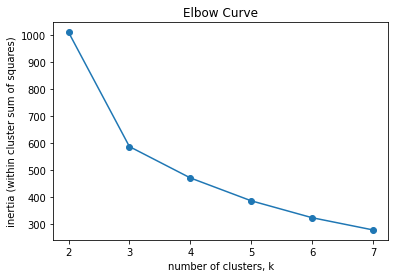

In [31]:
# Plot ks vs inertias (wcss)
plt.plot(ks, wcss, '-o')
plt.title("Elbow Curve")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia (within cluster sum of squares)')
plt.xticks(ks)
plt.show()

Clearly, we can see from the graph that 3 is a good number of clusters, since these are points where the inertia begins to decrease more slowly. In fact, the grain samples come from a mix of 3 different grain varieties: `Kama, Rosa and Canadian`. 

Now, let's compare the clusters to the grain varieties using a cross-tabulation. 

In [32]:
# Create model with 3 clusters
model = KMeans(n_clusters=3)
labels = model.fit_predict(samples)

In [33]:
# Create seeds dataframe
seeds_df = pd.DataFrame({'labels': labels, 'varieties': varieties})
seeds_df.head()

,labels,varieties
0,1,Kama wheat
1,1,Kama wheat
2,1,Kama wheat
3,1,Kama wheat
4,1,Kama wheat


In [34]:
# Create cross-tabulation
ct = pd.crosstab(seeds_df['labels'], seeds_df['varieties'])
ct

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
0,0,1,60
1,2,60,10
2,68,9,0


Now as it clear from cross-tabulation, our model did a pretty good job.